In [71]:
import numpy as np
import matplotlib.pyplot as plt

from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch
from datetime import datetime

# Configure matplotlib for LaTeX rendering
plt.rcParams.update({
    'text.usetex': False,  # Disable LaTeX to use system fonts
    'font.family': 'sans-serif',
    'font.sans-serif': ['Arial'],  # Impact first, fallbacks
    'font.size': 20,
    'axes.labelsize': 25,
    'axes.titlesize': 25,
    'legend.fontsize': 25,
    'xtick.labelsize': 30,
    'ytick.labelsize': 30,
    'figure.titlesize': 30,
    'pgf.rcfonts': False,  # Use LaTeX default fonts for PGF
    'pgf.preamble': r'\usepackage{amsmath}\usepackage{amsfonts}'
})

from plot.multicurve import MultiCurvePlotter
from plot.log_dual_plot import LogDualPlot

from core.nodes.transmission_node import TransmissionNode
from core.nodes.computing_node import ComputingNode

# Complete Offloading

- No computing on User Satellite in Offloading case
- Variation of $\phi_\text{ec}$
- Ratio $S_\text{isl} / S_\text{gl}$

In [72]:
with_legend = True
plot_precision = 1000

data_size = 100
phi_min = 0.0  # Minimum phi value
phi_max = 1.5  # Maximum phi value


In [73]:
config = {
    "base": {
        "obdh": {
            "speed": 30.0,
            "phi": 0.9,
            "energy_uptime": 1,
            "energy_io": 0.001
        },
        "ground_link": {
            "speed": 10.0,
            "energy": 5,
            "distance": 700
        }
    },
    "offloading": {
        "user_satellite": {
            "obdh": { # No computing on the user satellite in this scenario
                "phi": None,
                "speed": None,
                "energy_uptime": None,
                "energy_io": None
            },
            "isl": {
                "speed": None, # Exploring ISL speed variation
                "energy": 3,
                "distance": 100
            }
        },
        "edge_node": {
            "edge_computer": {
                "phi": None, # Exploring EC phi variation
                "speed": 300.0,
                "energy_uptime": 50,
                "energy_io": 0.001
            },
            "ground_link": {
                "speed": None, # Exploring GL speed variation
                "energy": 5,
                "distance": 700
            }
        }
    }
}

# Base Case

- Computing on User Satellite (OBDH)
- Ground Link

In [74]:
base_obdh_speed = config['base']['obdh']['speed']
base_odbh_phi = config['base']['obdh']['phi']
base_obdh_energy_uptime = config['base']['obdh']['energy_uptime']
base_obdh_energy_io = config['base']['obdh']['energy_io']

# Base Case - calculate reference costs
base_time_cost = 0
base_energy_cost = 0

obc = ComputingNode(
    speed=base_obdh_speed,
    phi=base_odbh_phi
)

base_time_cost += obc.time_cost(data_size)
base_energy_cost += obc.energy_cost(
    data_size,
    energy_uptime=base_obdh_energy_uptime,
    energy_io=base_obdh_energy_io
)

d_out_obc = obc.process(data_size)

base_ground_link_speed = config['base']['ground_link']['speed']
base_ground_link_energy = config['base']['ground_link']['energy']
base_ground_link_distance = config['base']['ground_link']['distance']

ground_link = TransmissionNode(
    speed=base_ground_link_speed
)

base_time_cost += ground_link.time_cost(d_out_obc)
base_energy_cost += ground_link.energy_cost(
    d_out_obc,
    energy=base_ground_link_energy,
    distance=base_ground_link_distance
)

print(f"Base case - Time: {base_time_cost:.3f}s, Energy: {base_energy_cost:.3f}J")

Base case - Time: 12.333s, Energy: 131.463J


In [75]:
n_satellites = range(1, 10, 1)
phi_en = 0.5
s_isl = base_ground_link_speed * 1.6
print(f"N satelites : {n_satellites}")
print(f"s_isl : {s_isl}")

N satelites : range(1, 10)
s_isl : 16.0


# Offloading Case

- No computing on User Satellite
- ISL to Edge Node
- Computing on Edge Node
- Edge Node ground link

In [76]:
time_costs = []
energy_costs = []

# Variation of Usr ISL
# isl_speed = config['offloading']['user_satellite']['isl']['speed']
off_isl_energy = config['offloading']['user_satellite']['isl']['energy']
off_isl_distance = config['offloading']['user_satellite']['isl']['distance']

off_edge_computer_speed = config['offloading']['edge_node']['edge_computer']['speed']
# Variation of EC phi
# edge_computer_phi = config['offloading']['edge_node']['edge_computer']['phi']
off_edge_computer_energy_uptime = config['offloading']['edge_node']['edge_computer']['energy_uptime']
off_edge_computer_energy_io = config['offloading']['edge_node']['edge_computer']['energy_io']

# Variation of EN gl
# off_ground_link_speed = config['offloading']['edge_node']['ground_link']['speed']
off_ground_link_energy = config['offloading']['edge_node']['ground_link']['energy']
off_ground_link_distance = config['offloading']['edge_node']['ground_link']['distance']

print("Computing cost grid...")

# ISL transmission
isl = TransmissionNode(speed=float(s_isl))
after_isl_iteration_time_cost = isl.time_cost(data_size)
after_isl_iteration_energy_cost = isl.energy_cost(
    data_size,
    energy=off_isl_energy,
    distance=off_isl_distance
)

for i, n in enumerate(n_satellites):
    print(f"Satellite {n}...")

    d_out_isl = isl.process(data_size)

    edge_computer = ComputingNode(
        speed=off_edge_computer_speed,
        phi=phi_en
    )

    iteration_time_cost = after_isl_iteration_time_cost + edge_computer.time_cost(data_size)
    iteration_energy_cost = after_isl_iteration_energy_cost + edge_computer.energy_cost(
        d_out_isl,
        energy_uptime=off_edge_computer_energy_uptime,
        energy_io=off_edge_computer_energy_io
    )

    d_out_ec = edge_computer.process(data_size)

    if n > 1:
        for _ in range(n-1):
            # Edge computing with current phi value
            edge_computer = ComputingNode(
                speed=off_edge_computer_speed,
                phi=phi_en
            )

            iteration_time_cost += edge_computer.time_cost(data_size)
            iteration_energy_cost += edge_computer.energy_cost(
                d_out_ec,
                energy_uptime=off_edge_computer_energy_uptime,
                energy_io=off_edge_computer_energy_io
            )

            d_out_ec = edge_computer.process(d_out_ec)

            en_isl = TransmissionNode(speed=float(s_isl))
            iteration_time_cost += en_isl.time_cost(data_size)
            iteration_energy_cost += en_isl.energy_cost(
                d_out_ec,
                energy=off_isl_energy,
                distance=off_isl_distance
            )

            d_out_ec = en_isl.process(d_out_ec)

    # Ground link transmission (fixed speed)
    ground_link = TransmissionNode(speed=float(base_ground_link_speed))
    iteration_time_cost += ground_link.time_cost(d_out_ec)
    iteration_energy_cost += ground_link.energy_cost(
        d_out_ec,
        energy=off_ground_link_energy,
        distance=off_ground_link_distance
    )

    # Total costs
    time_costs.append(iteration_time_cost)
    energy_costs.append(iteration_energy_cost)

Computing cost grid...
Satellite 1...
Satellite 2...
Satellite 3...
Satellite 4...
Satellite 5...
Satellite 6...
Satellite 7...
Satellite 8...
Satellite 9...


[11.583333333333332, 15.666666666666666, 20.95, 26.933333333333334, 33.21666666666666, 39.6, 46.083333333333336, 52.66666666666667, 59.25000000000001]
[125.39411766702308, 107.58872550017821, 97.78725490675221, 93.51396078670945, 91.37731372668806, 89.4102156866738, 88.15533333333333, 88.15533333333333, 88.15533333333333]


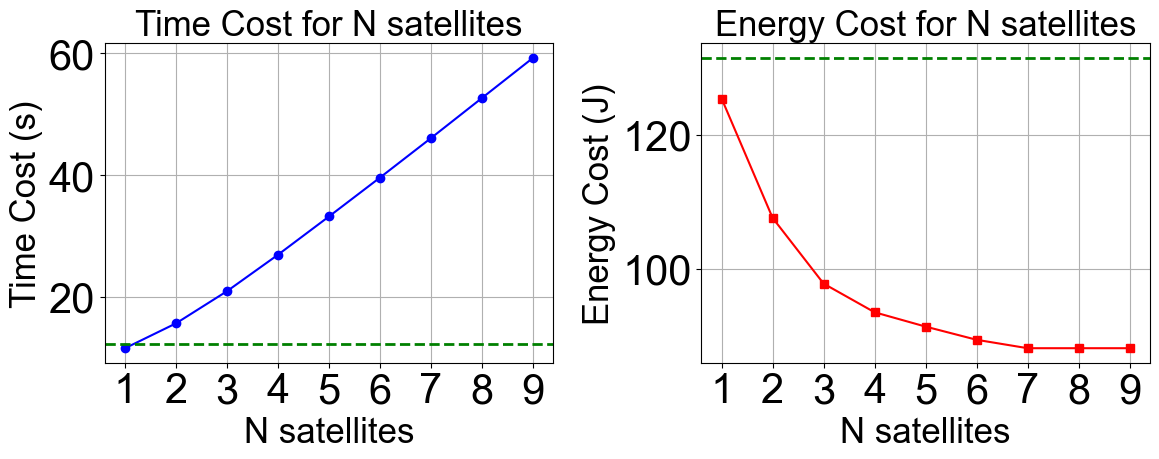

In [77]:
print(time_costs)
print(energy_costs)

# Create a figure with 2 subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# First plot
ax1.plot(n_satellites, time_costs, marker='o', color='blue')
ax1.axhline(y=base_time_cost, color='green', linestyle='--', linewidth=2, label='Threshold')
ax1.set_xlabel('N satellites')
ax1.set_ylabel('Time Cost (s)')
ax1.set_title('Time Cost for N satellites')
ax1.set_xticks(n_satellites)
ax1.grid(True)

# Second plot
ax2.plot(n_satellites, energy_costs, marker='s', color='red')
ax2.axhline(y=base_energy_cost, color='green', linestyle='--', linewidth=2, label='Threshold')
ax2.set_xlabel('N satellites')
ax2.set_ylabel('Energy Cost (J)')
ax2.set_title('Energy Cost for N satellites')
ax2.set_xticks(n_satellites)
ax2.grid(True)

# Adjust layout to prevent overlap
plt.tight_layout()

# Display the plots
plt.show()